In [1]:
# Parameters
bcmap = "pipeline/OCNT-DMSLIB-1-run2/"


## DMS Barcode Mapping Report

1. [Sequencing Quality Metrics](#part1)
2. [Read Sampling Distributions](#part2)
3. [Library Complexity and Coverage](#part3)
4. [RY Barcoding](#part4)

### Sequencing Quality Metrics <a name="part1"></a>

#### Sequencing Depth 

In [2]:
library(patchwork)
library(ggseqlogo)
library(tidyfast)
library(vroom)
library(ggpubr)
library(fs)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(tidyverse)

datadir <- bcmap

Loading required package: ggplot2

Registered S3 methods overwritten by 'readr':
  method                    from 
  as.data.frame.spec_tbl_df vroom
  as_tibble.spec_tbl_df     vroom
  format.col_spec           vroom
  print.col_spec            vroom
  print.collector           vroom
  print.date_names          vroom
  print.locale              vroom
  str.col_spec              vroom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.5          ✔ dplyr   1.0.7     
✔ tidyr   1.1.4          ✔ stringr 1.5.0.9000
✔ readr   2.0.2          ✔ forcats 0.5.1     
✔ purrr   0.3.4          

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_character()  masks vroom::col_character()
✖ readr::col_date()       masks vroom::col_date()
✖ readr::col_datetime()   masks vroom::col_datetime()
✖ readr::col_double()     masks vroom::col_double()
✖ readr::col_factor()     masks vroom::col_factor()
✖ readr::col_guess() 

In [3]:
depths <- read_tsv(paste0(datadir, "/multiqc_data/multiqc_flash_combo_stats.txt")) %>%
    select(Sample, totalpairs) %>%
    rename(sample = Sample, `read count` = totalpairs) %>%
    mutate(group = gsub("A.*|B.*","",sample))

depths_plot_log <- ggplot(depths) + 
    geom_bar(aes(y = fct_rev(sample), x = `read count`, fill = group, color = group),
             position = "dodge",
             stat = "identity") +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    scale_x_continuous(trans = "log10",breaks = 10**c(1:9)) +
    xlab("log10(read count)") + ylab("") + theme(legend.position = "none")

depths_plot <- ggplot(depths) + 
    geom_bar(aes(y = fct_rev(sample), x = `read count`, fill = group, color = group),
             position = "dodge",
             stat = "identity") +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    ylab("sample") + theme(legend.position = "none")

Rows: 16 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Sample, s_name
dbl (7): totalpairs, discardpairs, percdiscard, inniepairs, outiepairs, unco...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


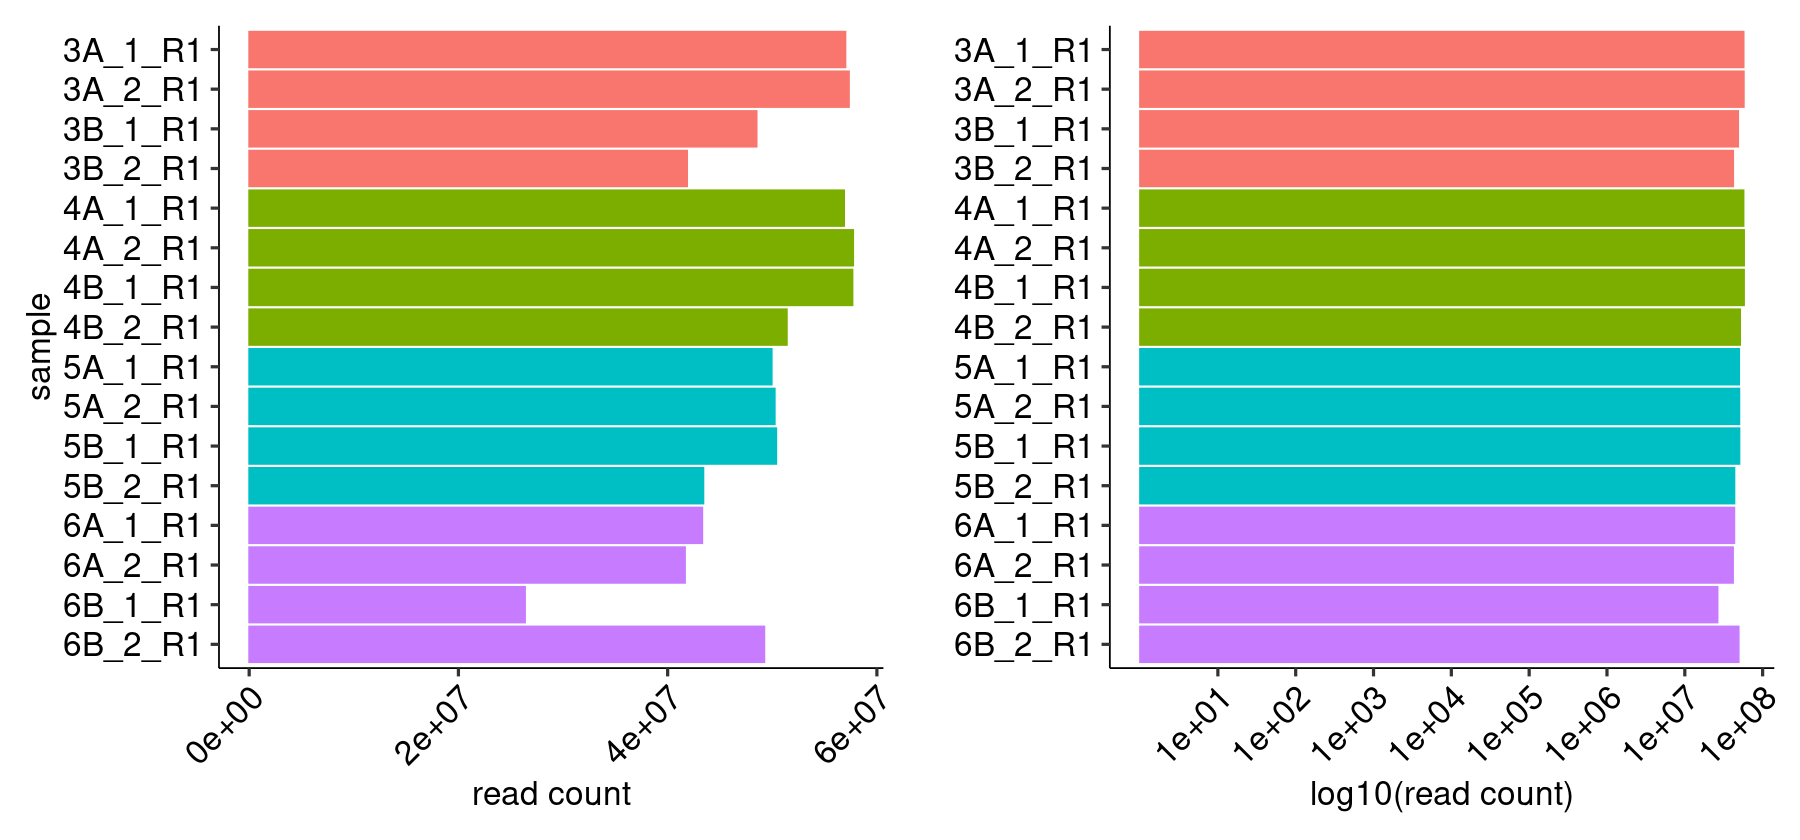

In [4]:
options(repr.plot.height = 7, repr.plot.width = 15)
depths_plot + depths_plot_log

In [5]:
depth_table <- depths %>%
    select(sample, `read count`)

In [6]:
knitr::kable(depth_table, format = "markdown")



|sample  | read count|
|:-------|----------:|
|3A_1_R1 |   56995569|
|3A_2_R1 |   57329625|
|3B_1_R1 |   48504137|
|3B_2_R1 |   41862423|
|4A_1_R1 |   56866293|
|4A_2_R1 |   57735109|
|4B_1_R1 |   57669587|
|4B_2_R1 |   51393103|
|5A_1_R1 |   49946515|
|5A_2_R1 |   50238182|
|5B_1_R1 |   50381602|
|5B_2_R1 |   43417816|
|6A_1_R1 |   43311834|
|6A_2_R1 |   41659294|
|6B_1_R1 |   26367894|
|6B_2_R1 |   49243114|

#### R1/R2 Joining

In [7]:
flash_log <- read_tsv(paste0(datadir, "/multiqc_data/multiqc_flash_combo_stats.txt")) %>%
                select(Sample,inniepairs,uncombopairs) %>%
                rename("Valid Pairs" = "inniepairs",
                       "Unmerged" = "uncombopairs") %>%
                pivot_longer(names_to = "metric", values_to = "value", `Valid Pairs`:Unmerged) %>%
                mutate(Sample = gsub("_R1","",Sample))

flash_plot <- ggplot(flash_log) +
    geom_bar(aes(y = Sample, x = value, fill = metric), position = "dodge", stat = "identity") +
    scale_x_continuous(trans = "log10",breaks = 10**c(1:10)) +
    theme_pubr(base_size = 14, x.text.angle = 45) +
    ylab("") +
    xlab("log10(count)")

Rows: 16 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Sample, s_name
dbl (7): totalpairs, discardpairs, percdiscard, inniepairs, outiepairs, unco...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


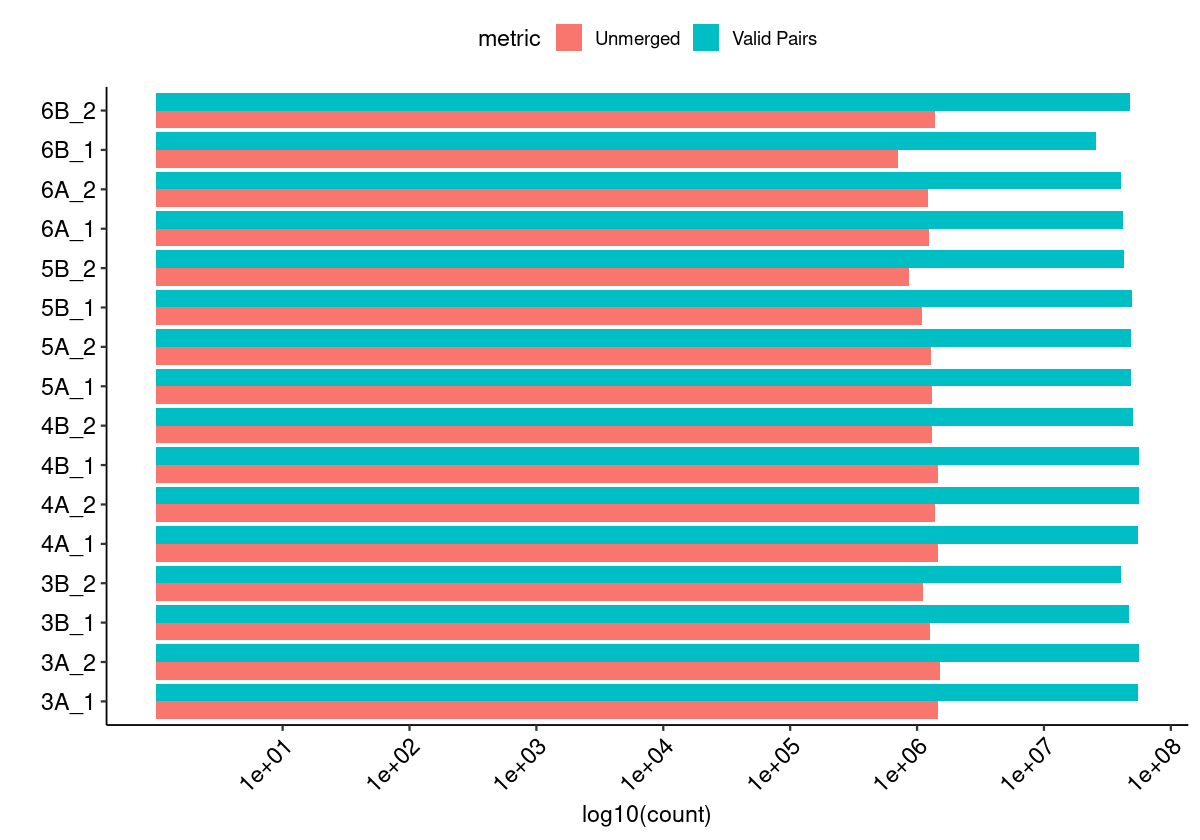

In [8]:
options(repr.plot.height = 7, repr.plot.width = 10)

flash_plot

#### Merged Fragment Lengths

In [9]:
files <- dir_ls(path = datadir ,glob = "*hist")
names(files) <- gsub(".*/","",files)
names(files) <- gsub(".hist","",names(files))

flash_length <- files %>% map_dfr(read_tsv, col_names = c("length","count"), .id = "source") %>%
    mutate(length = as.numeric(as.character(length)),
           chunk = gsub("A.*|B.*","",source,perl=T))
    
length_plot <- ggplot(flash_length) +
    geom_line(aes(x = length, y = count, group = interaction(source, chunk), color = chunk)) +
    theme_pubr(base_size = 16) + coord_cartesian(c(270,295))

Rows: 263 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 262 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 260 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): length, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 254 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter:

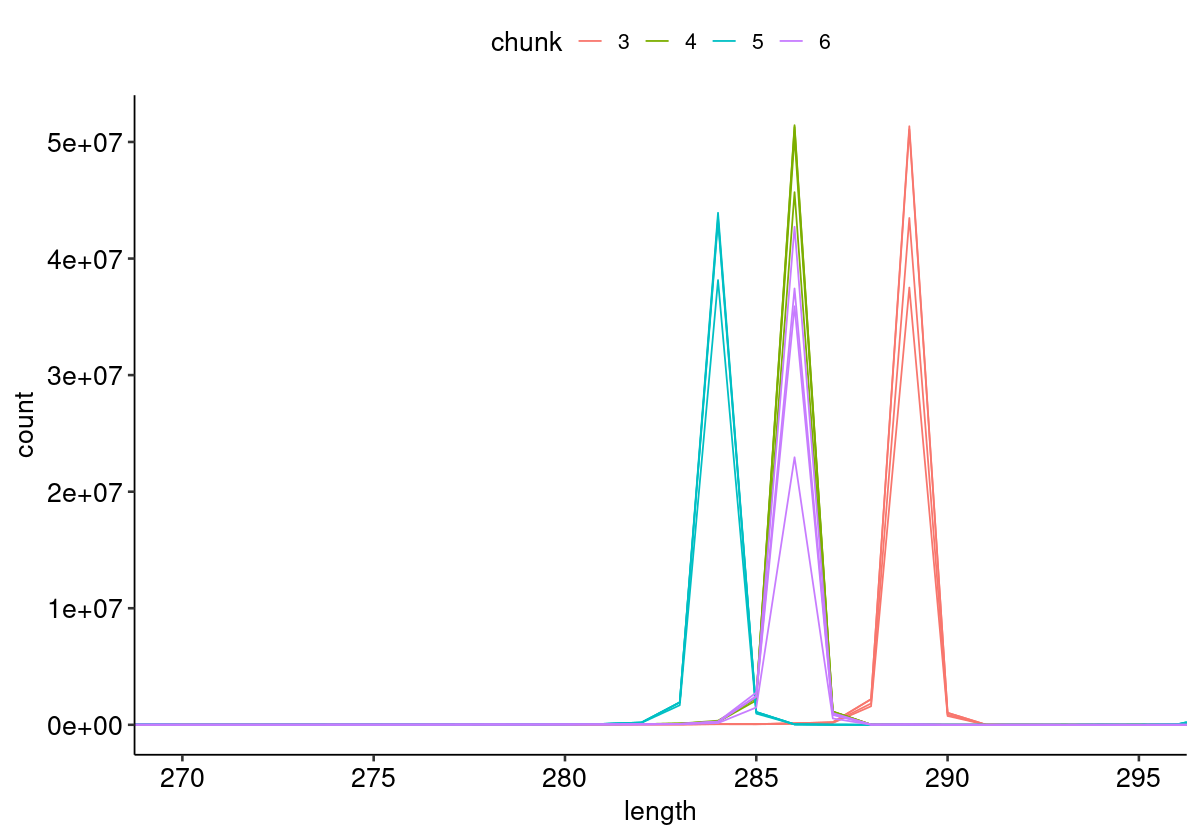

In [10]:
length_plot

#### Unique Alignment Rate <a name="part2c"></a>

In [11]:
star_qc <- read_tsv(paste0(datadir, "/multiqc_data/multiqc_star.txt")) %>%
    select(Sample,uniquely_mapped_percent,multimapped_toomany_percent) %>%
    rename("Uniquely Mapped" = "uniquely_mapped_percent",
           "Multi-Mapped" = "multimapped_toomany_percent") %>%
    pivot_longer(names_to = "metric", values_to = "value", `Uniquely Mapped`:`Multi-Mapped`)

align_plot <- ggplot(star_qc) +
    geom_bar(aes(x = value, y = Sample, fill = metric), position = "dodge", stat = "identity") +
    theme_pubr(base_size = 16) +
    theme(legend.title = element_blank()) +
    xlab("Percent")

Rows: 16 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): total_reads, avg_input_read_length, uniquely_mapped, uniquely_mapp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


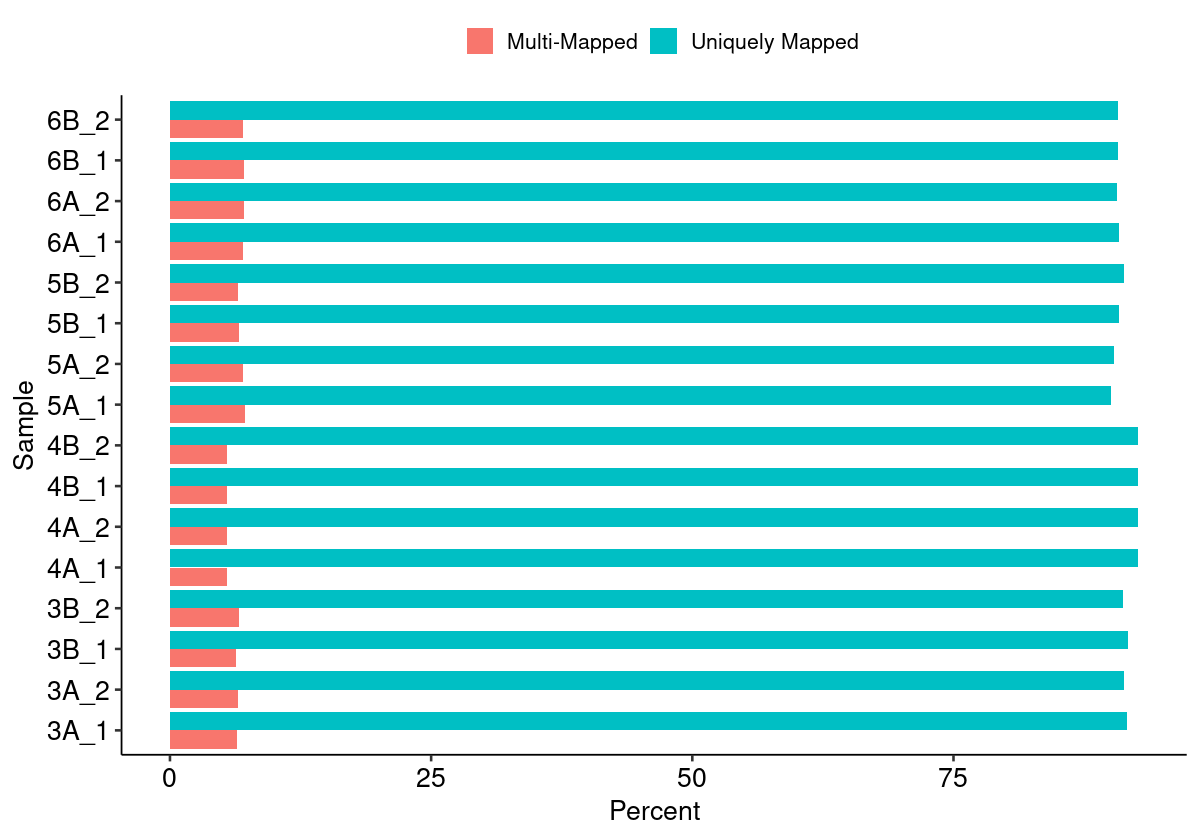

In [12]:
align_plot

#### Edit Distance Distributions

In [13]:
files <- dir_ls(datadir, glob = "*mismatchCounts*")
names(files) <- gsub(".*/|.mismatchCounts.tsv","",files)
nmcounts <- files %>% 
    map_dfr(read_tsv, col_names = c("count","mismatches"), .id = "source") %>%
    mutate(mismatches = if_else(mismatches >= 11, 11, mismatches)) %>%
    group_by(source, mismatches) %>%
    summarize(count = sum(count))

Rows: 11 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, mismatches

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, mismatches

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, mismatches

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11 Columns: 2
── Column specification ────────────────────────────────────────────────────────
De

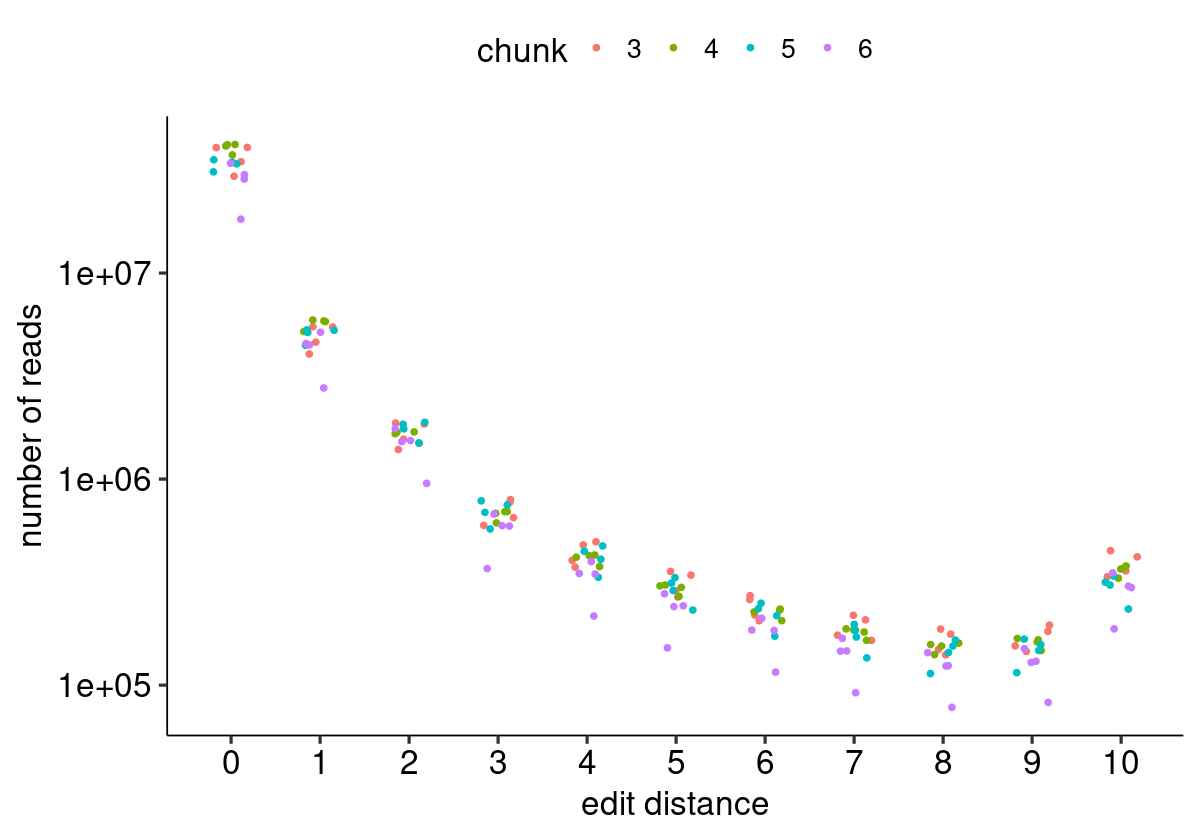

In [14]:
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot(nmcounts %>% mutate(chunk = gsub("A_.|B_.","",source,perl=T))) +
    geom_point(aes(x = mismatches, y =  count, color = chunk), position=position_jitter(width = 0.2)) +
    theme_pubr(base_size = 20) +
    scale_x_continuous(breaks = 0:11, labels = c(0:10,">10")) +
    scale_y_log10() +
    xlab("edit distance") + ylab("number of reads")

#### Edit Distance Proportion Distributions

In [15]:
props <- nmcounts %>%
    group_by(source) %>%
    mutate(count = count/sum(count),
           chunk = gsub("A.*|B.*","",source))

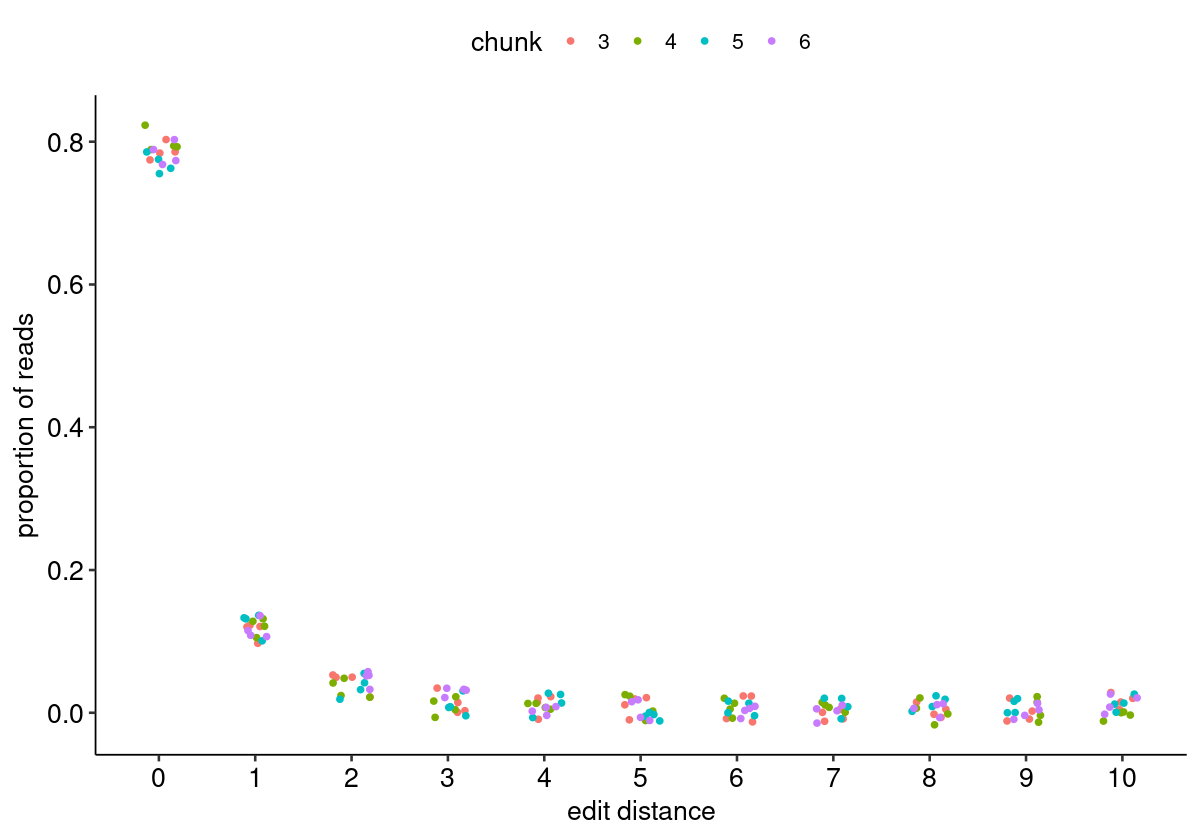

In [16]:
ggplot(props) +
    geom_point(aes(x = mismatches, y = count, color = chunk), position=position_jitter(width = 0.2, height = 0.02)) +
    theme_pubr(base_size = 16) +
    xlab("edit distance") + ylab("proportion of reads") +
    scale_x_continuous(breaks = 0:11, labels = c(0:10,">10"))

#### Reproduced Associations Per Barcode Sequence

In [17]:
files <- dir_ls(datadir, glob = "*countRepVarPerBc*")
names(files) <- gsub(".*/|.countRepVarPerBc.tsv","",files)

varcounts <- files %>%
    map_dfr(read_tsv, col_names = c("count","numVariants"), .id = "source") %>%
    mutate(numVariants = if_else(numVariants >= 11, 11, numVariants)) %>%
    group_by(source, numVariants) %>%
    summarize(count = sum(count))

repPlot <- ggplot(varcounts) +
    geom_point(aes(x = numVariants, y = count, color = source)) +
    geom_line(aes(x = numVariants, y = count, color = source)) +
    theme_pubr(base_size = 16) +
    scale_x_continuous(breaks = c(1:11), labels = c(1:10,">10")) +
    xlab("Number of Reproduced Associations\nPer Barcode")

repPlotLog <- ggplot(varcounts) +
    geom_point(aes(x = numVariants, y = count, color = source)) +
    geom_line(aes(x = numVariants, y = count, color = source)) +
    theme_pubr(base_size = 16) +
    scale_x_continuous(breaks = c(1:11), labels = c(1:10,">10")) +
    scale_y_log10() +
    xlab("Number of Reproduced Associations\nPer Barcode") +
    ylab("count")

Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, numVariants

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 16 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, numVariants

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 17 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): count, numVariants

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 17 Columns: 2
── Column specification ────────────────────────────────────────────────────────

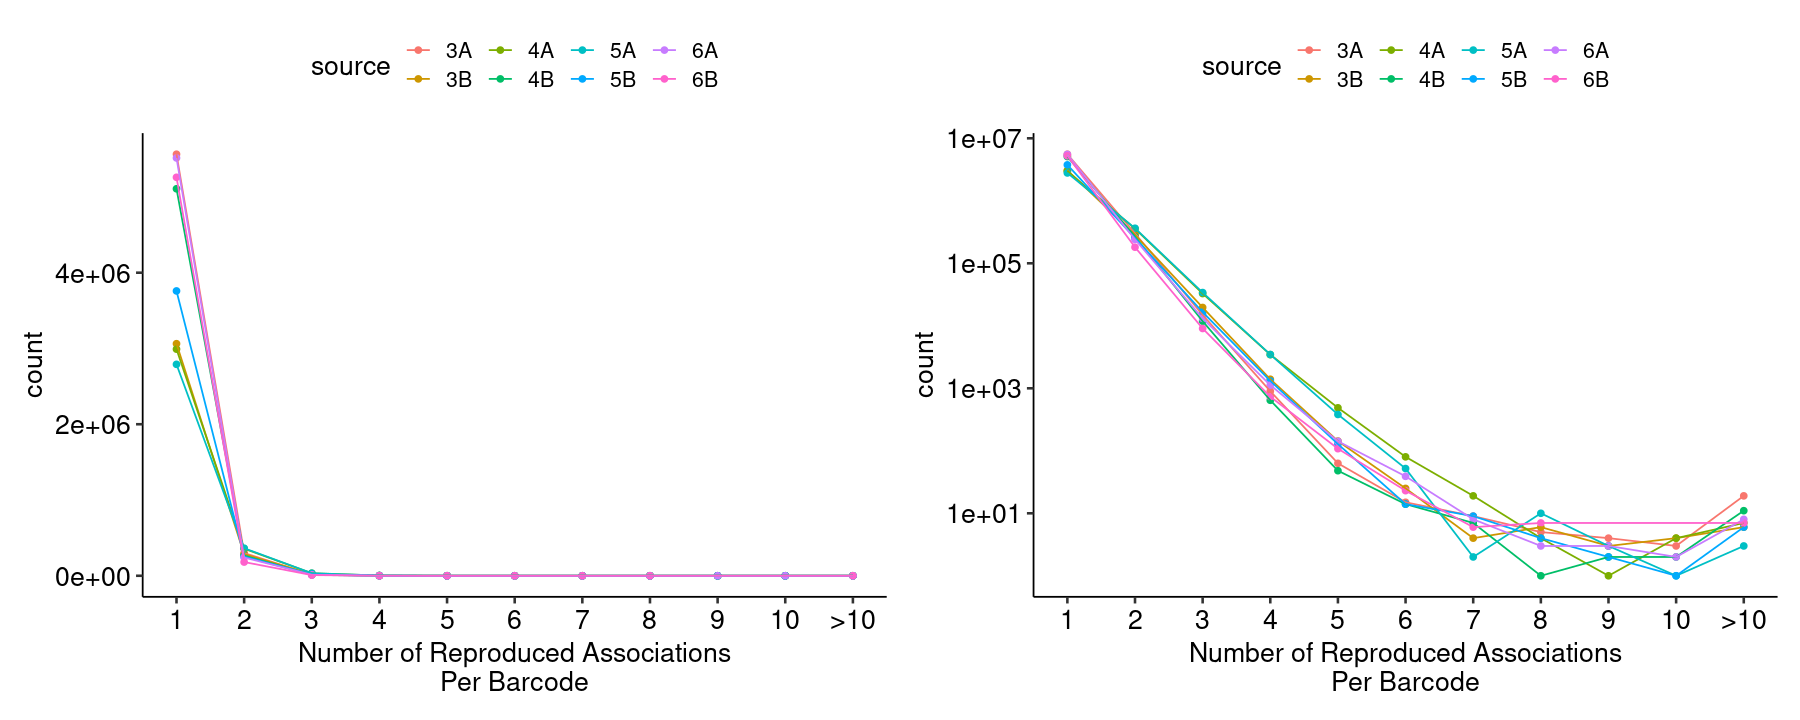

In [18]:
options(repr.plot.width = 15, repr.plot.height = 6)
repPlot + repPlotLog

#### Filtered Barcode Counts Per Replicate Group

In [19]:
dist_data <- dir_ls(datadir, glob = "*bcmap-filtered-split*")
dist_data <- vroom(dist_data, id = "sample", col_types = c(.default = "n", "oligo" = "c")) %>%
    dt_separate(oligo, c("lib", "chunk", "wt_aa", "pos",
                         "mut_aa", "wt_codon", "mut_codon"), sep = "_")

In [20]:
bccount <- dist_data %>% 
    count(sample) %>%
    mutate(sample = gsub(paste0(datadir, "|-split.tsv"), "", sample))

In [21]:
bccount %>%
    knitr::kable(format = "markdown", align = "l")



|sample            |n       |
|:-----------------|:-------|
|3A.bcmap-filtered |5016187 |
|3B.bcmap-filtered |2758136 |
|4A.bcmap-filtered |2656574 |
|4B.bcmap-filtered |4544991 |
|5A.bcmap-filtered |2429781 |
|5B.bcmap-filtered |3279812 |
|6A.bcmap-filtered |4813287 |
|6B.bcmap-filtered |4596939 |

### Read Sampling Distributions <a name="part3"></a>

#### Reads Per Barcode Without Binning

In [22]:
counts_per_bc_1 <- dist_data %>%
    group_by(sample, rep1_readcount) %>%
    summarize(numBcWithCount = n()) %>%
    mutate(sample = gsub(paste0(datadir, "|-split.tsv"), "", sample),
           rep = "1") %>%
    rename("count" = "rep1_readcount") %>%
    drop_na()

counts_per_bc_2 <- dist_data %>%
    group_by(sample, rep2_readcount) %>%
    summarize(numBcWithCount = n()) %>%
    mutate(sample = gsub(paste0(datadir, "|-split.tsv"), "", sample),
           rep = "2")  %>%
    rename("count" = "rep2_readcount") %>%
    drop_na()

counts_per_bc <- bind_rows(counts_per_bc_1, counts_per_bc_2)

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


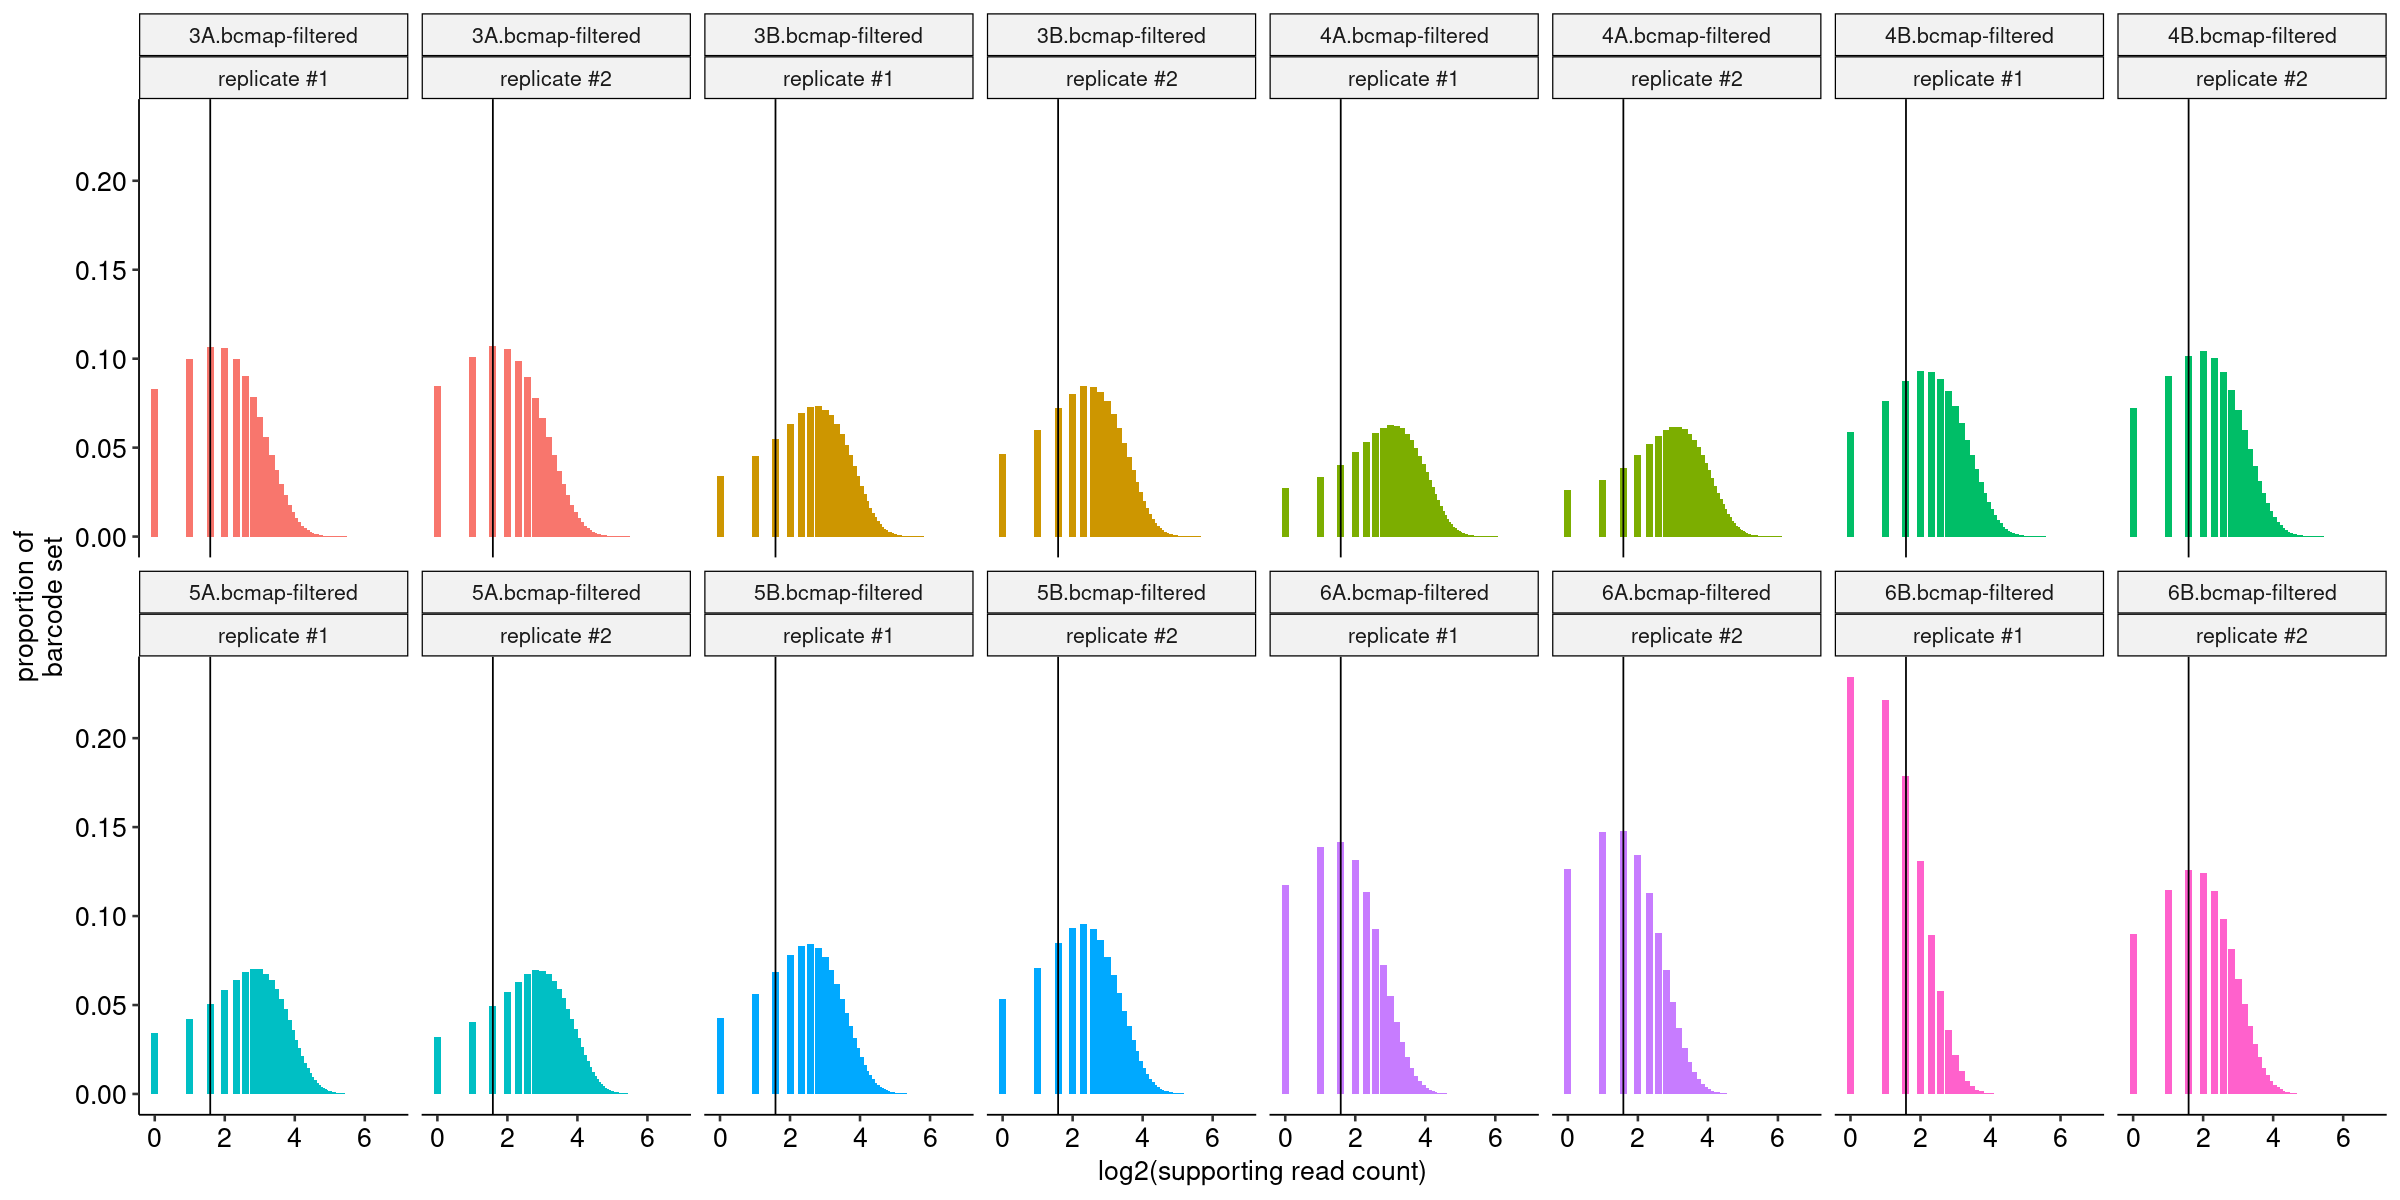

In [23]:
options(repr.plot.width = 20, repr.plot.height = 10, warn = -1)
counts_per_bc %>%
    group_by(sample, rep) %>%
    mutate(count = log2(count),
           total = sum(numBcWithCount)) %>%
    ggplot() +
        geom_bar(aes(x = count, y = numBcWithCount/total, fill = sample), width = 0.2, stat = "identity") +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample + paste0("replicate #", rep), nrow = 2) +
        theme(legend.position = "none") +
        xlab("log2(supporting read count)") + ylab("proportion of\nbarcode set") +
        geom_vline(xintercept = log2(3))

#### Reads Per Barcode With Binning

In [24]:
counts_per_bc_binned <- counts_per_bc %>% 
    mutate(count = log2(count),
           count_interval = cut_width(count, width = 1)) %>%
    select(sample, numBcWithCount, count_interval, rep) %>%
    group_by(sample, rep) %>%
    mutate(total = sum(numBcWithCount))

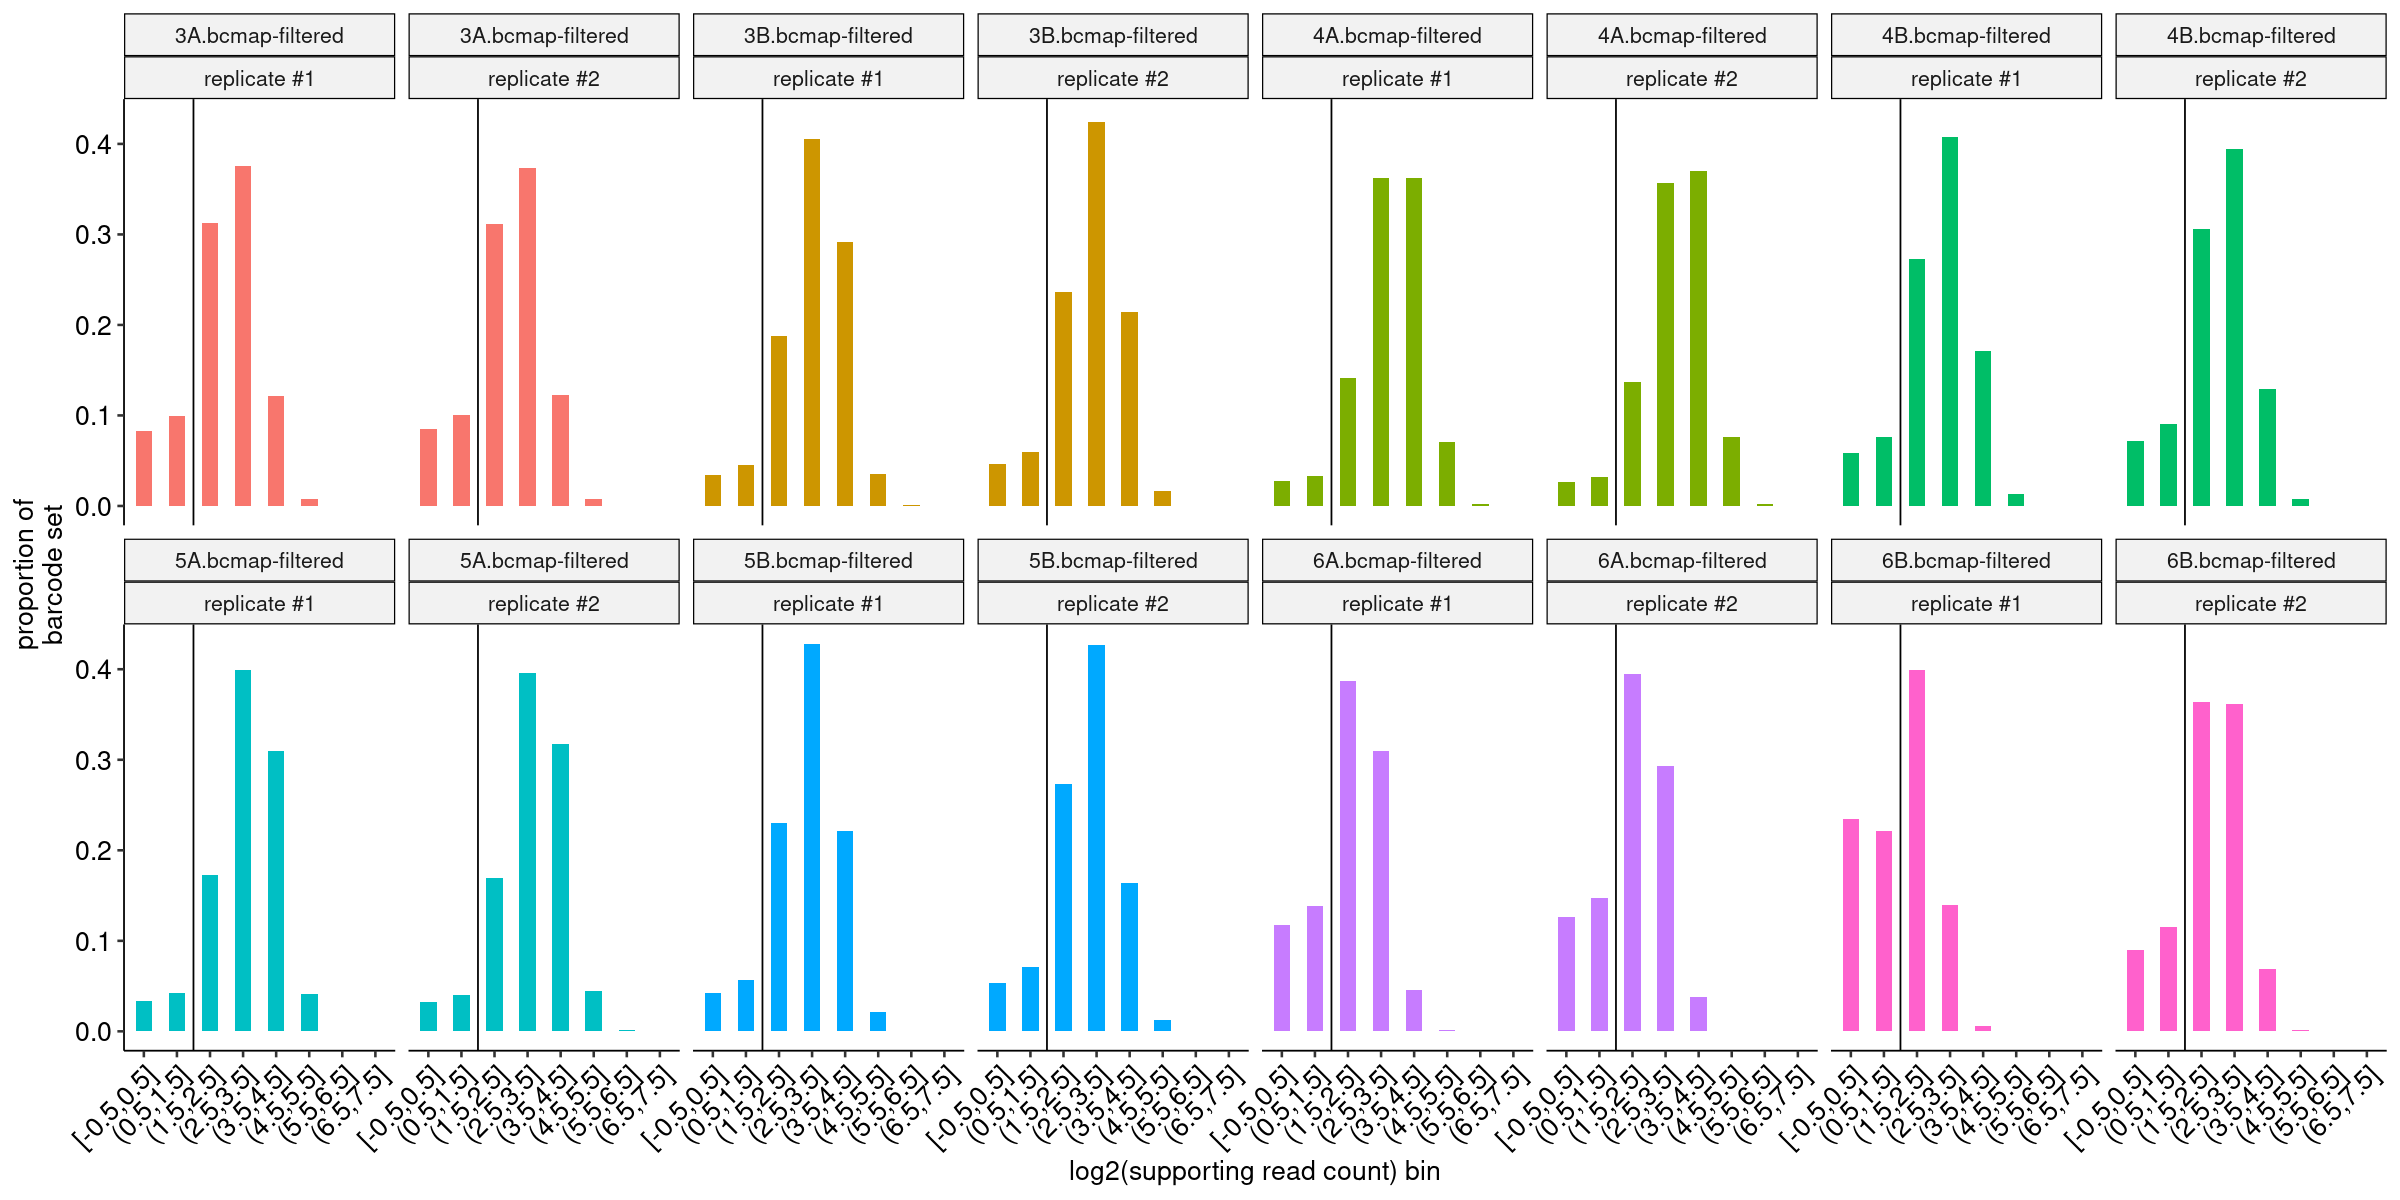

In [25]:
options(repr.plot.width = 20, repr.plot.height = 10, warn = -1)
ggplot(counts_per_bc_binned) +
        geom_bar(aes(x = count_interval, y = numBcWithCount/total, fill = sample), width = 0.5, stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        facet_wrap(~sample + paste0("replicate #", rep), nrow = 2) +
        theme(legend.position = "none") +
        xlab("log2(supporting read count) bin") + ylab("proportion of\nbarcode set") +
        geom_vline(xintercept = 2.5)

#### Barcode Purity Distributions

In [26]:
purities_bin <- dist_data %>% 
    mutate(rep1_purity = cut(rep1_readprop, breaks = seq(0,1,0.01), labels = 1:100, include.lowest = TRUE),
           rep2_purity = cut(rep2_readprop, breaks = seq(0,1,0.01), labels = 1:100, include.lowest = TRUE))

purities_counts <- purities_bin %>%
    select(sample, rep1_purity, rep2_purity) %>%
    pivot_longer(names_to = "rep", values_to = "purity", c(rep1_purity, rep2_purity)) %>%
    count(sample, rep, purity) %>%
    mutate(sample = gsub(paste0(datadir, "|-split.tsv"), "", sample))

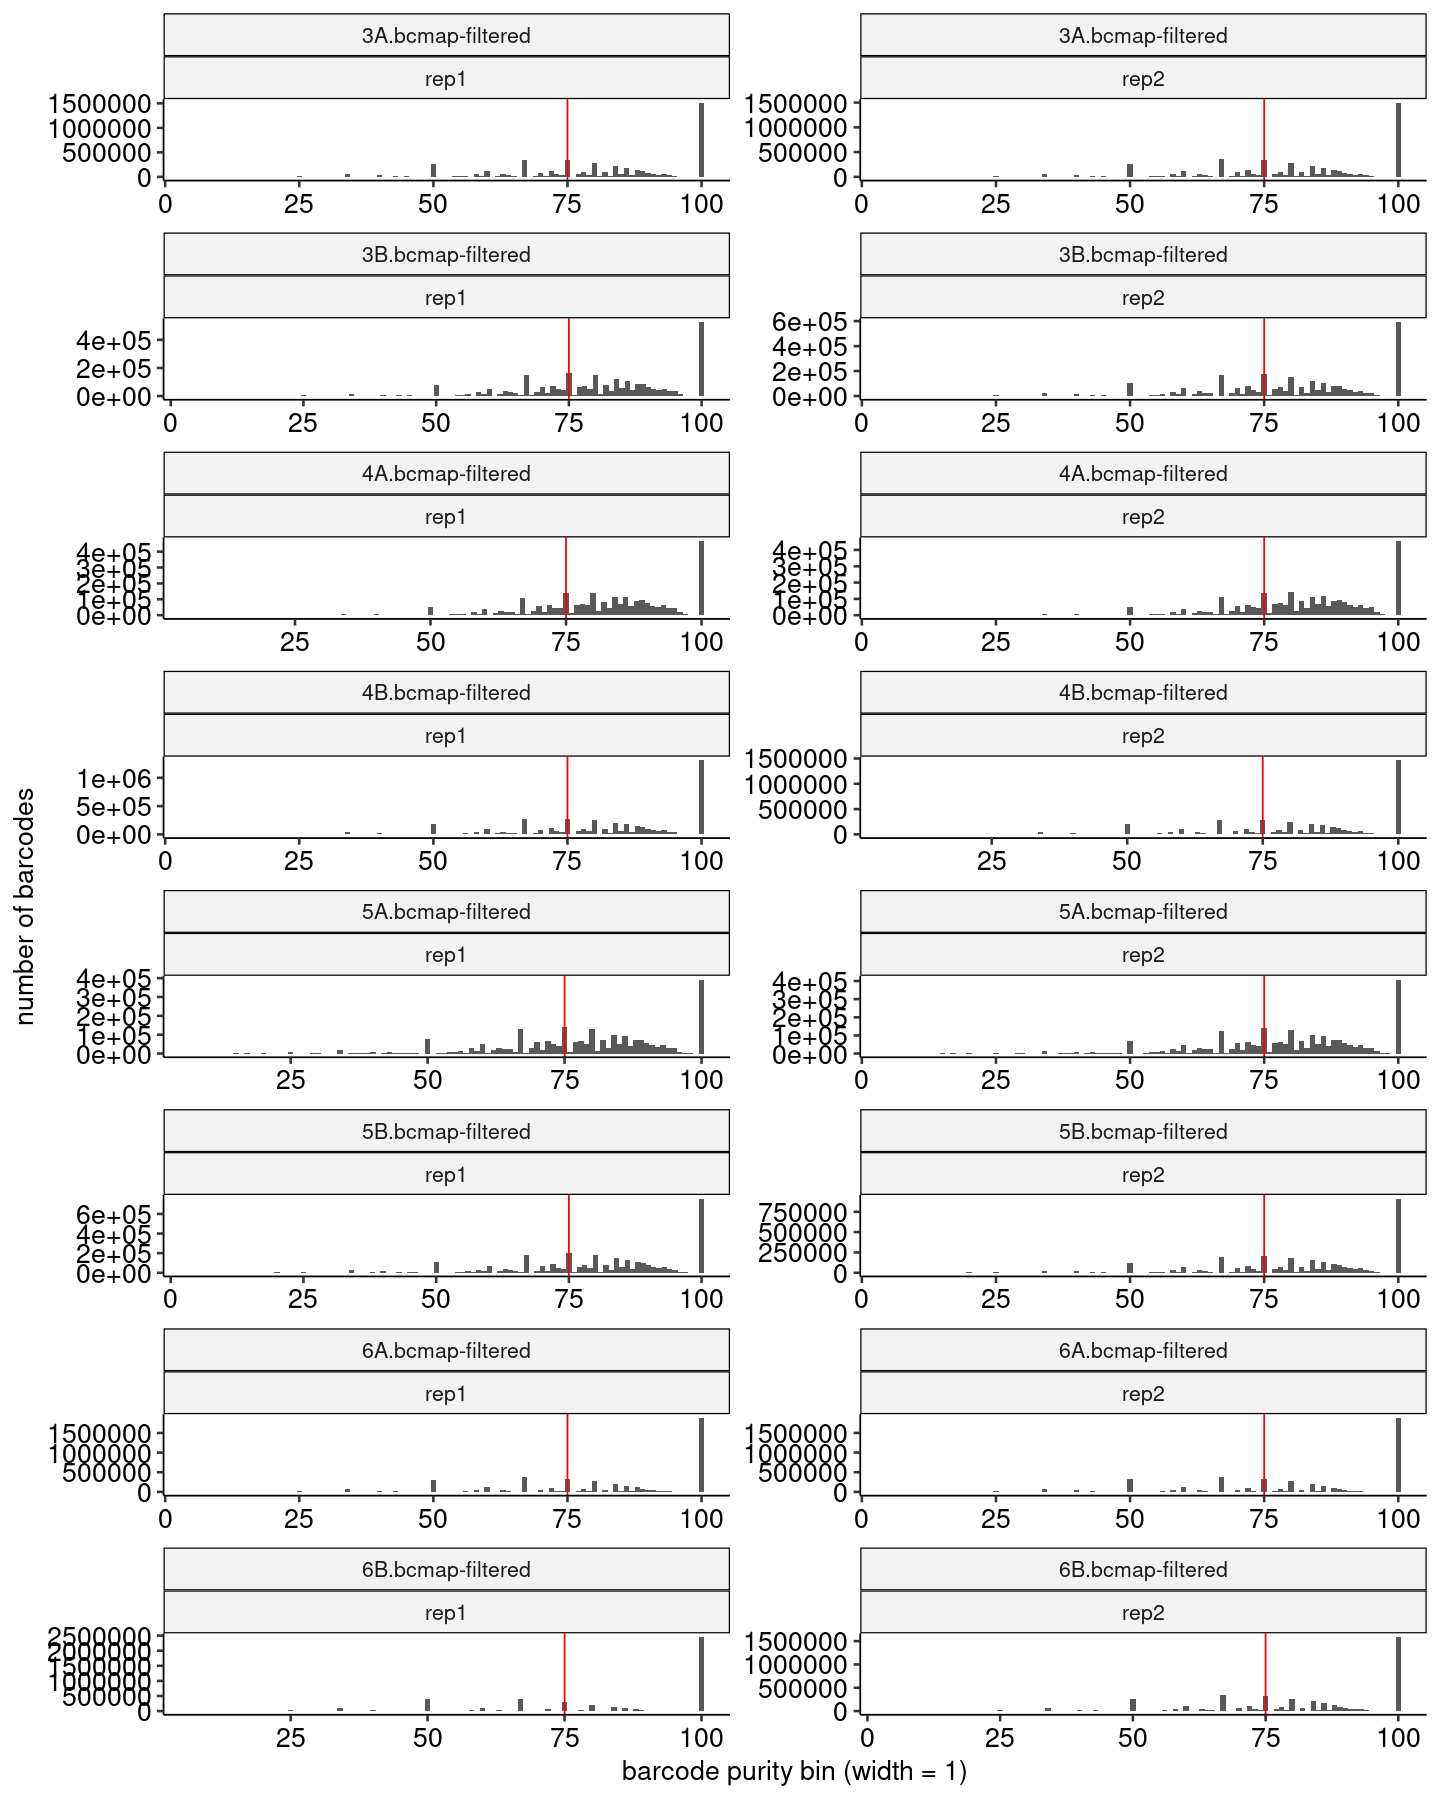

In [27]:
options(repr.plot.width = 12, repr.plot.height = 15, warn = -1)
ggplot(purities_counts) +
    geom_bar(aes(x = as.numeric(purity), y = n), stat = "identity", width = 1) +
    theme_pubr(base_size = 16) +
    facet_wrap(~sample + gsub("_.*", "", rep), ncol = 2, scales = "free") +
    theme(legend.position = "none") +
    xlab("barcode purity bin (width = 1)") + ylab("number of barcodes") +
    geom_vline(xintercept = 75, color = "red")

#### Barcode Counts Per Final Joined Map

In [3]:
bc_output <- system(paste0("wc -l ",datadir,"/*.bcmap-final.tsv"), intern = TRUE)
bc_output <- bc_output[-length(bc_output)]

bc_names <- lapply(bc_output, gsub,
                         pattern = paste0(".*", datadir, "/"),
                         replacement = "",
                         perl = T) %>% unlist()

bc_final_sizes <- lapply(bc_output, gsub,
                         pattern = "^ *| .*",
                         replacement = "",
                         perl = T) %>% unlist()

dist_data_counts <- tibble("sample" = bc_names,
                           "final barcode count" = bc_final_sizes)

In [4]:
dist_data_counts %>% knitr::kable(format = "markdown", align = "l")



|sample            |final barcode count |
|:-----------------|:-------------------|
|3.bcmap-final.tsv |3108897             |
|4.bcmap-final.tsv |3508914             |
|5.bcmap-final.tsv |2624160             |
|6.bcmap-final.tsv |2908148             |

### Library Complexity and Coverage <a name="part4"></a>

In [30]:
residue_counts <- dist_data %>%
    filter(rep1_readcount >= 3,
           rep2_readcount >= 3,
           rep1_readprop >= 0.75,
           rep2_readprop >= 0.75) %>%
    mutate(mut_aa = if_else(mut_aa == "X", "*", mut_aa)) %>%
    filter(wt_aa != mut_aa)

coverage_plot <- function(id, log10 = FALSE){
    
    data <- residue_counts %>% filter(sample == id)
    allpos <- unique(paste0(data$wt_aa, data$pos))
    
    data_counts <- data %>%
        mutate(pos = as.factor(pos),
           mut_aa = as.factor(mut_aa)) %>%
        group_by(sample, wt_aa, pos, mut_aa, .drop = FALSE) %>%
        summarize(num_bc = n()) %>%
        mutate(wt_aa = as.character(wt_aa),
                   pos = as.numeric(as.character(pos)),
                   mut_aa = as.character(mut_aa)) %>%
        filter(paste0(wt_aa, pos) %in% allpos,
               wt_aa != mut_aa)
    
    the_plot <- ggplot(data_counts) +
        geom_point(aes(x = as.numeric(pos), y = num_bc), stat = "identity") +
        geom_line(aes(x = as.numeric(pos), y = num_bc, group = mut_aa), stat = "identity") +
        facet_wrap(~mut_aa, nrow = 4) +
        theme_pubr(base_size = 16) +
        xlab("position") + ggtitle(id)
    
    if(log10){
        the_plot <- the_plot + ylab("log10(number of barcodes)") + scale_y_log10()
    } else {
        the_plot <- the_plot + ylab("number of barcodes")
    }
    
    return(the_plot)
}

coverage_plots <- lapply(as.list(unique(residue_counts$sample)), coverage_plot)
coverage_plots_log10 <- lapply(as.list(unique(residue_counts$sample)), coverage_plot, log10 = TRUE)

`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'wt_aa', 'pos'. You can override using the `.groups` argument.
`summarise()` has g

#### Unique Barcodes Per Residue

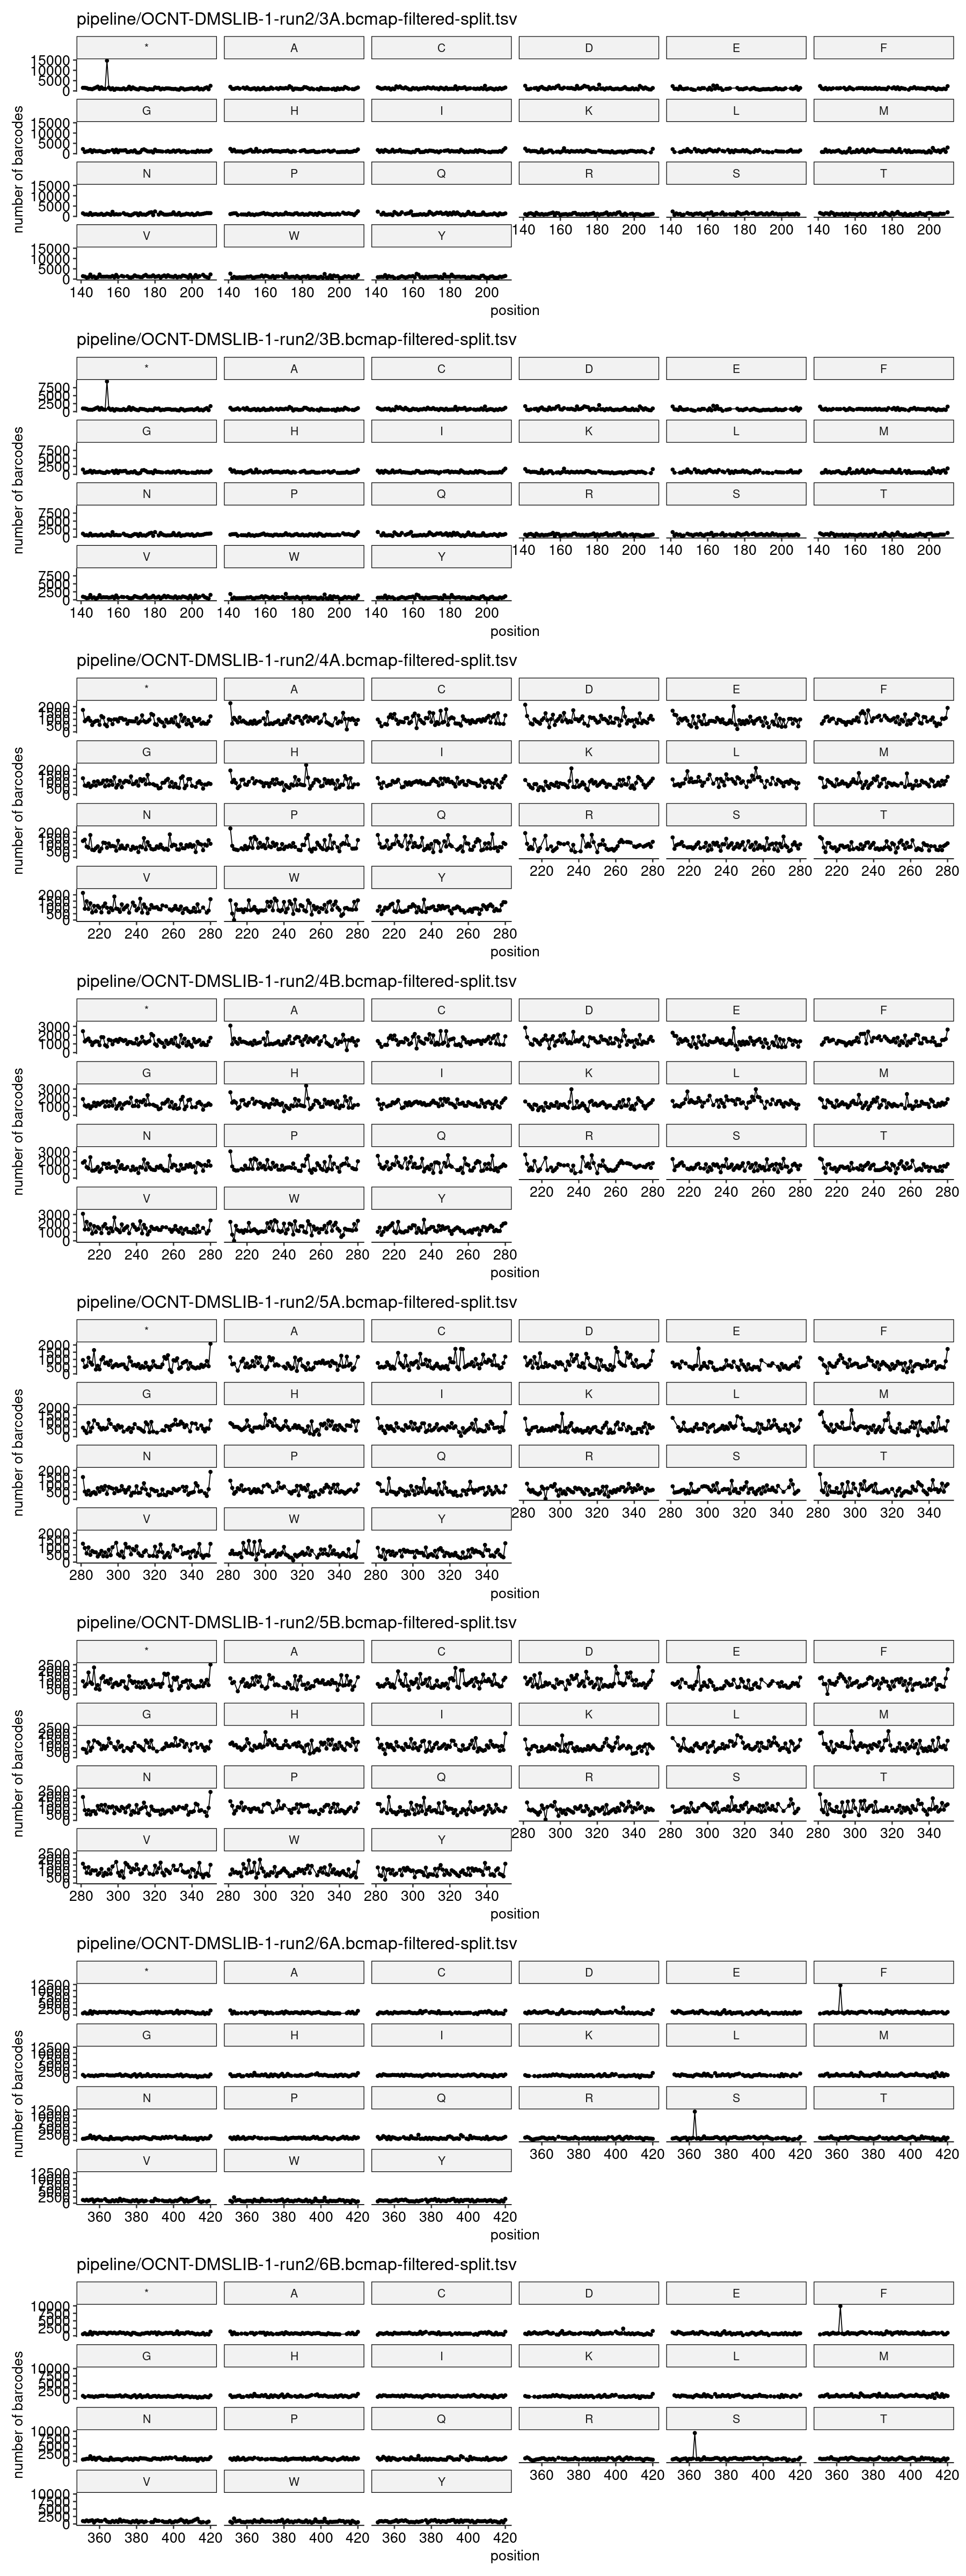

In [31]:
options(repr.plot.width = 15, repr.plot.height = 40)
wrap_plots(coverage_plots, ncol = 1)

#### Unique Barcodes Per Residue, log10

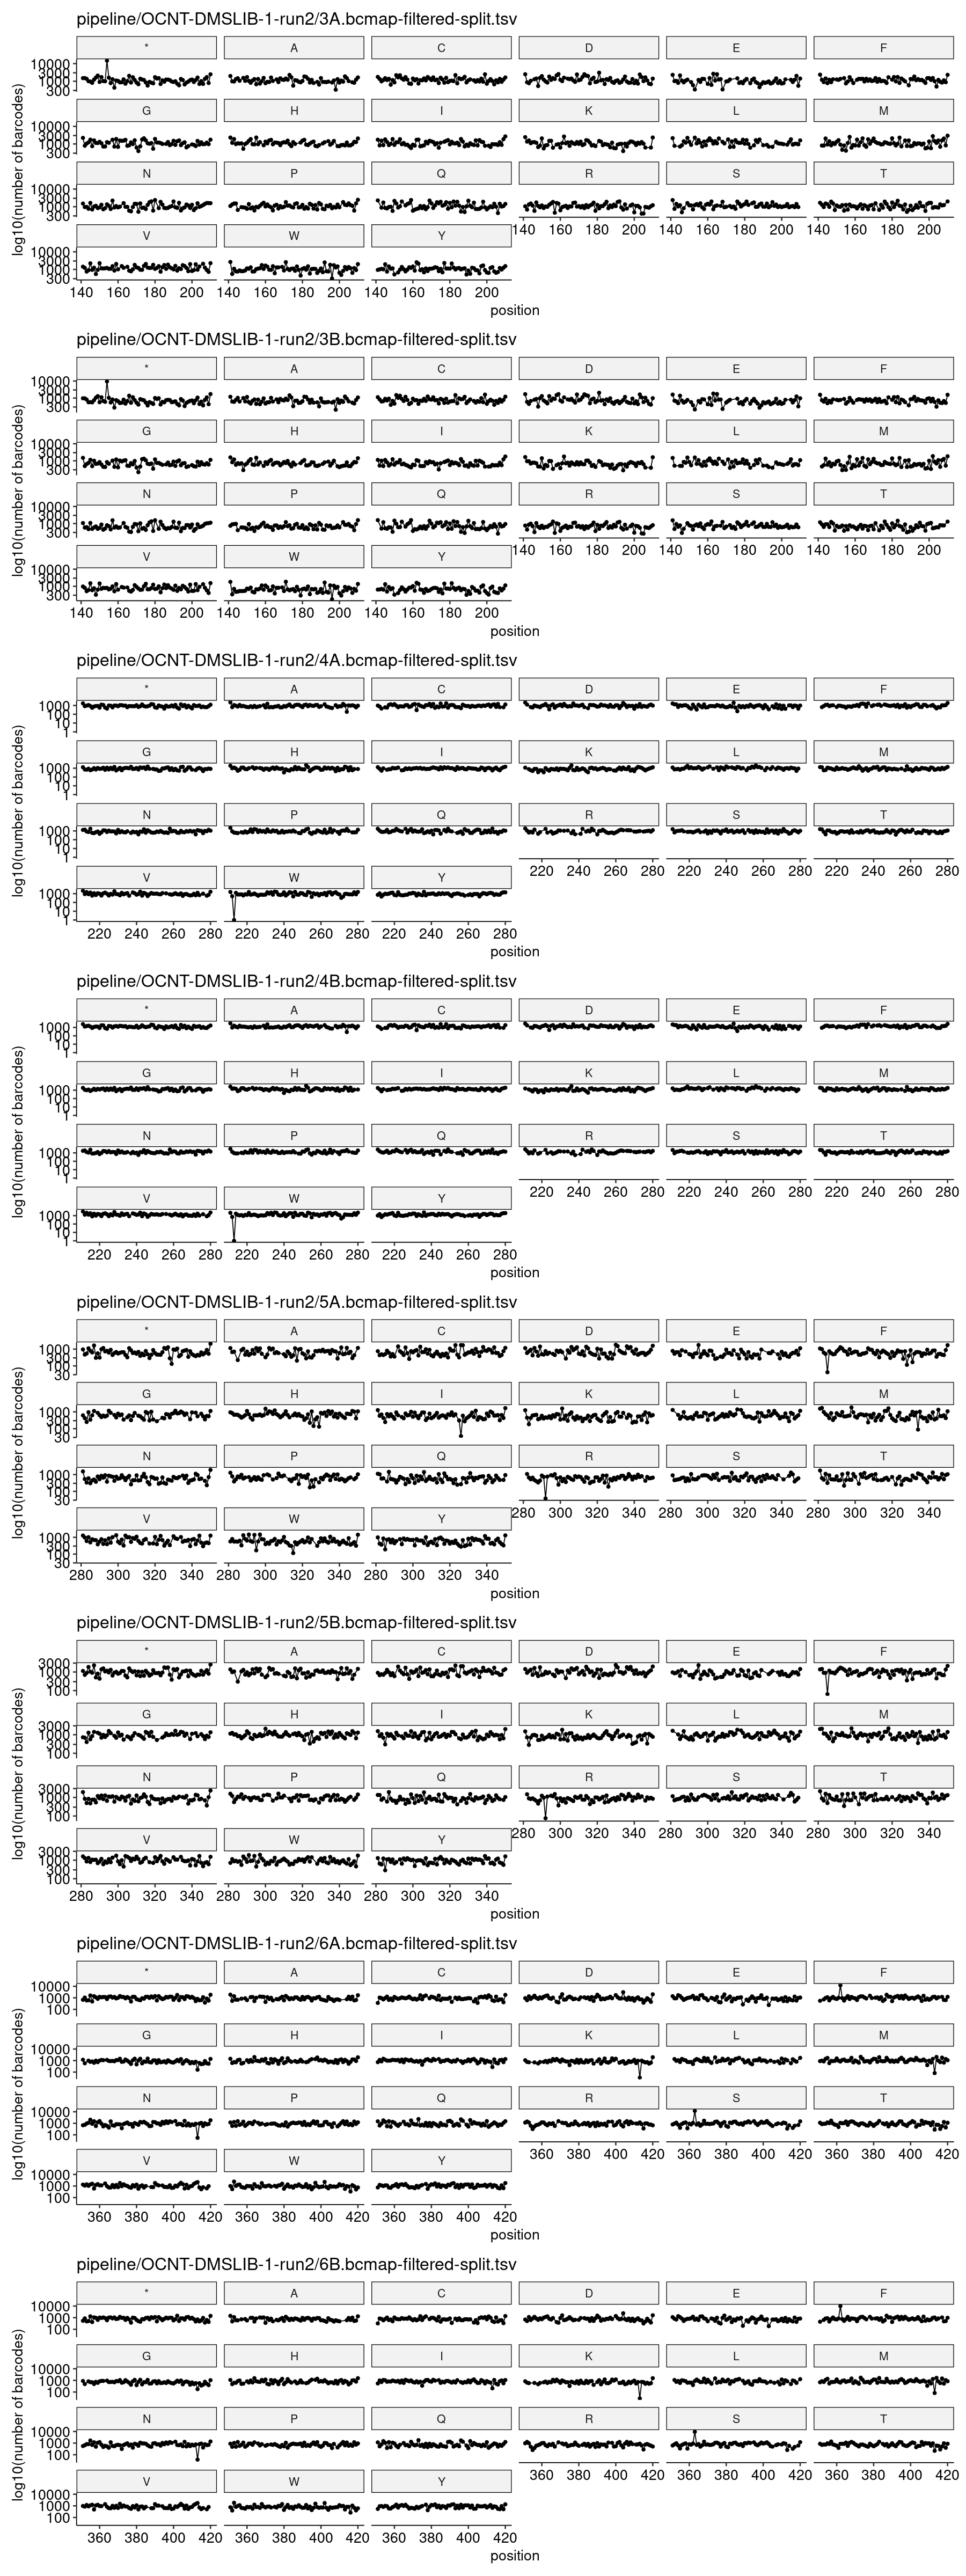

In [32]:
options(repr.plot.width = 15, repr.plot.height = 40, warn = -1)
wrap_plots(coverage_plots_log10, ncol = 1)

### RY Barcoding <a name="part5"></a>

In [33]:
plot_logo <- function(data, ident){
    
    d <- vroom(data, col_select = c("bc"), delim = "\t") 
    size = if_else(nrow(d) < 250000, nrow(d), as.integer(250000))
    
    logoplot <- ggseqlogo(sample(d$bc,
                                    size = size,
                                    replace = F),
                             method = 'probability',
                             seq_type='dna') + ggtitle(ident)
    
    return(logoplot)
}

In [34]:
files <- dir_ls(datadir, glob = "*filtered.tsv")
names(files) <- gsub(paste0(datadir,"|.bcmap-filtered.tsv"),"",files,perl=T)

plot_list <- list()

for(i in 1:length(files)){
    plot_list[[i]] <- plot_logo(files[i],names(files)[i])
}

Rows: 5016187 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): bc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2758136 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): bc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2656574 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): bc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4544991 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): bc

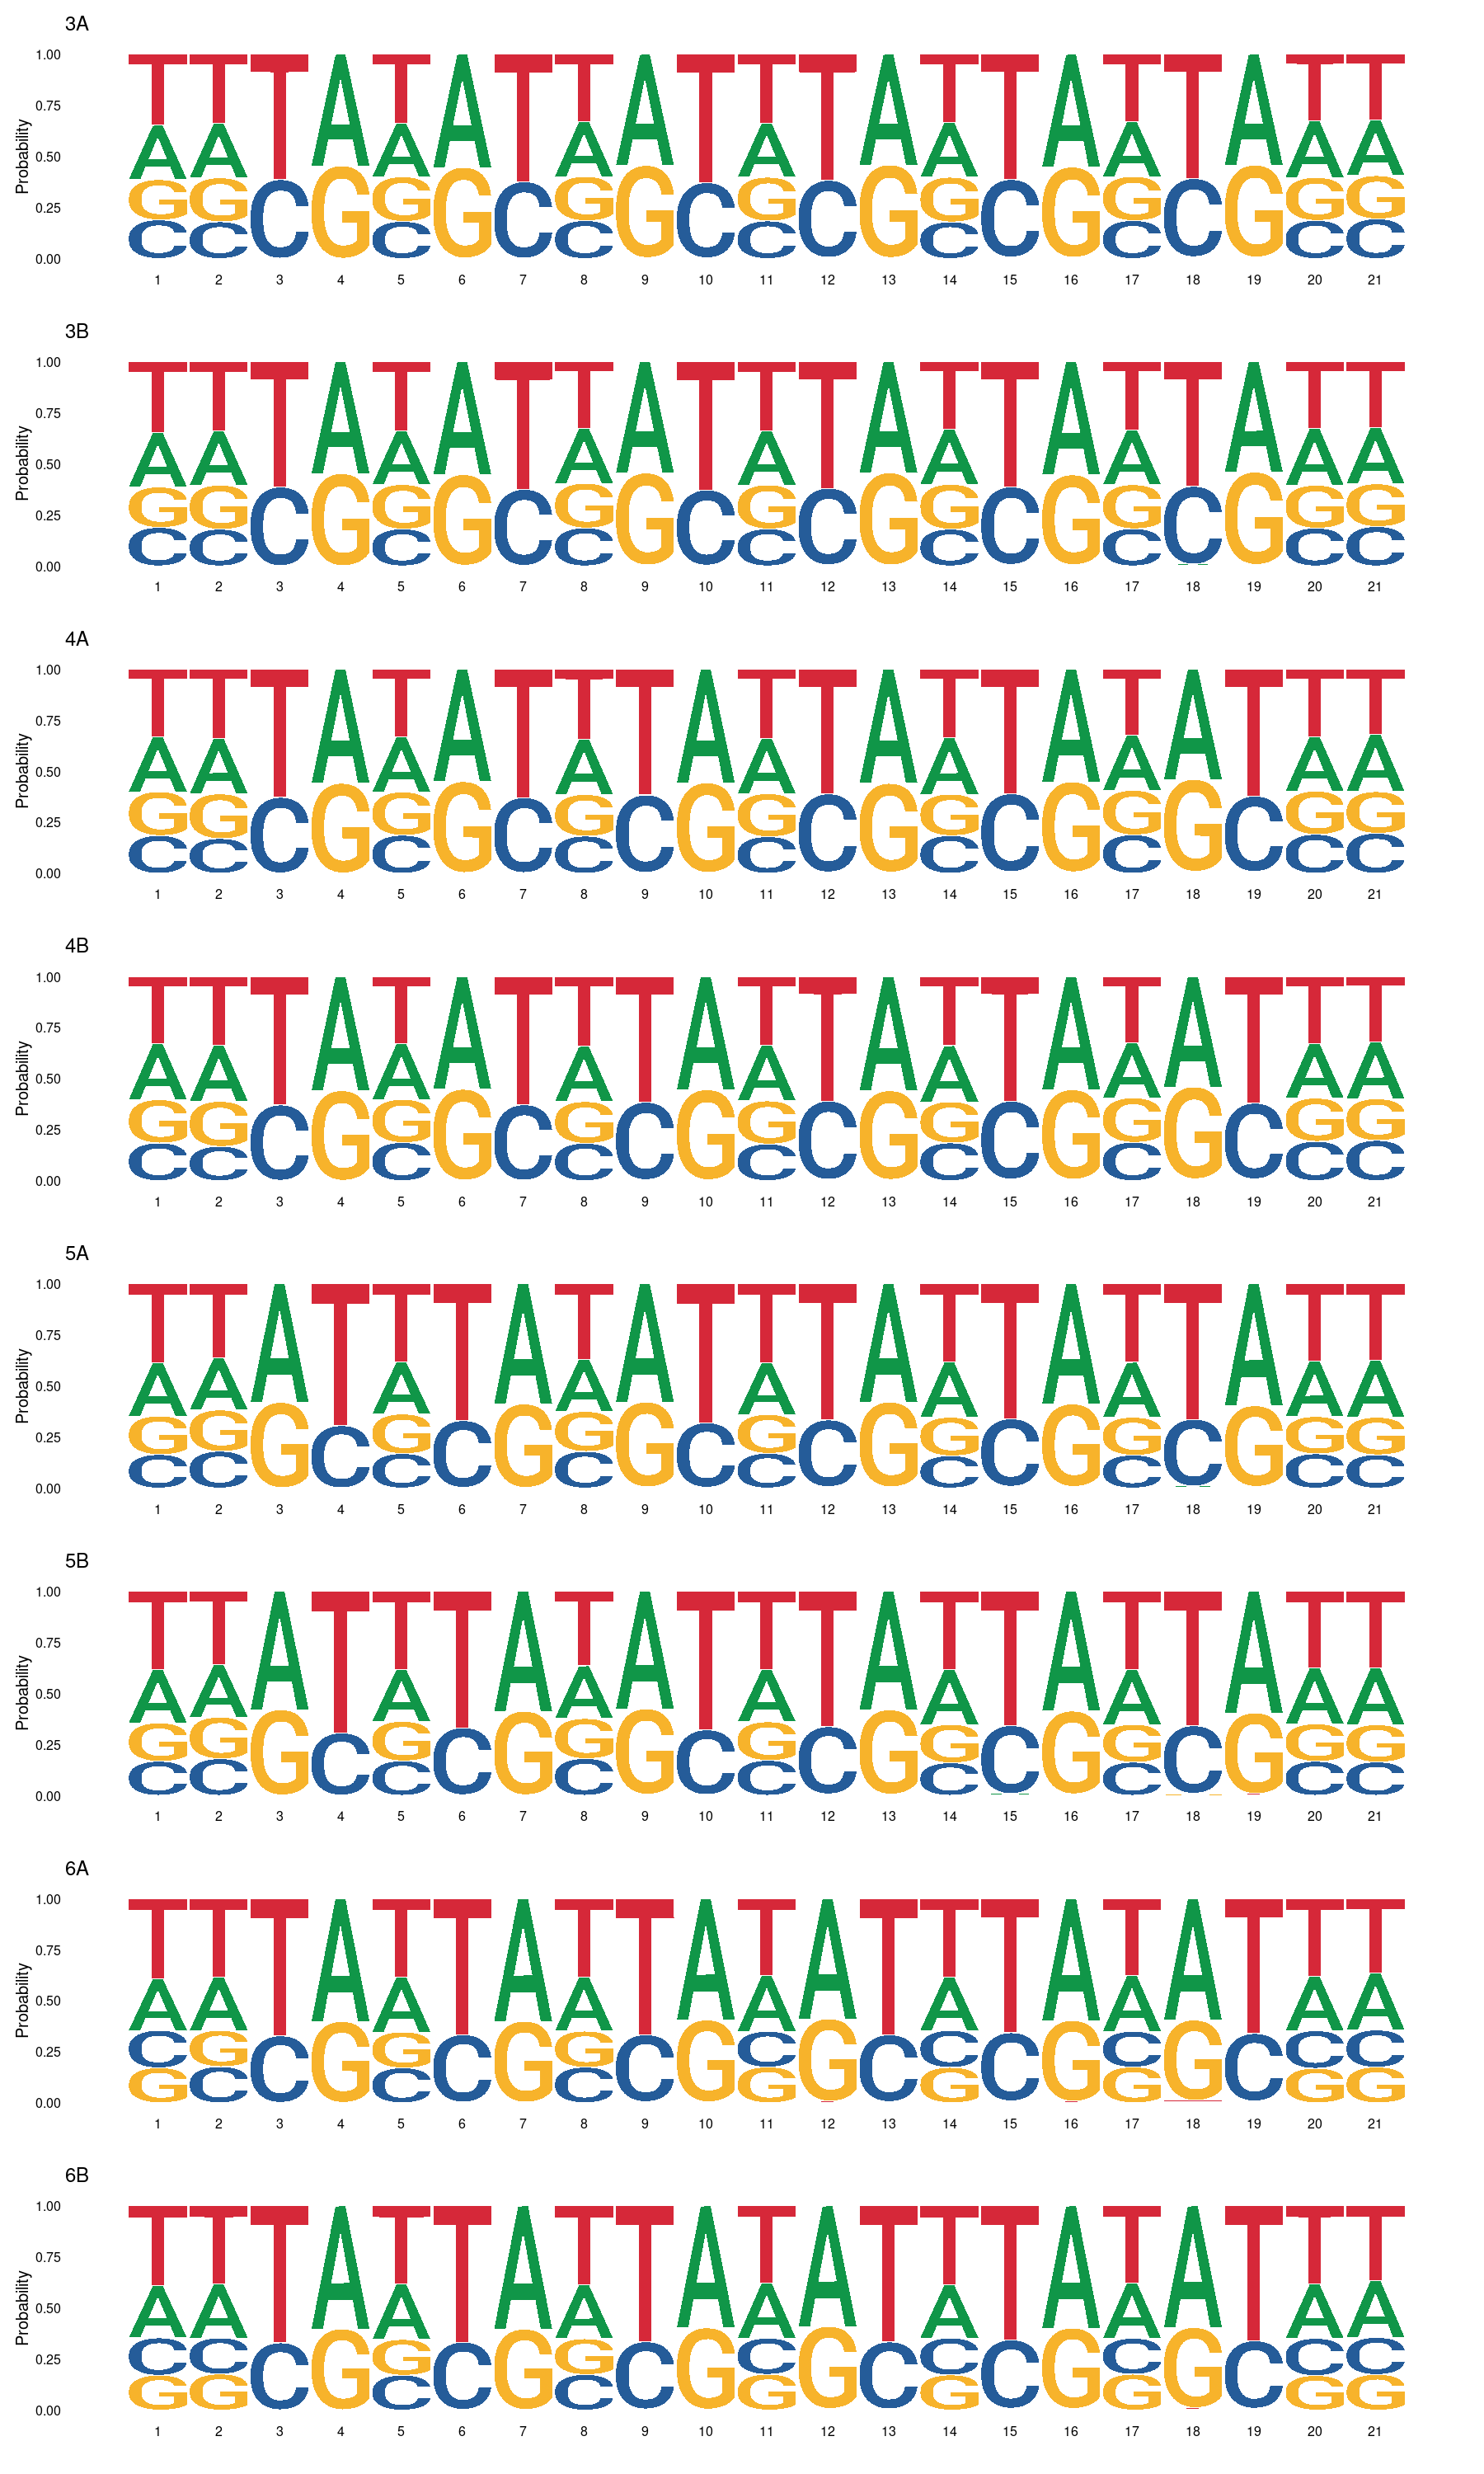

In [35]:
options(repr.plot.width = 15, repr.plot.height = 25)
wrap_plots(plot_list, ncol = 1)